# MLP

In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [3]:
import json
import os
import pathlib
import shutil

!export TF_CPP_MIN_LOG_LEVEL=3
!export TF_XLA_FLAGS=--tf_xla_enable_xla_devices

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm

In [4]:
available_gpus = tf.config.list_physical_devices("GPU")
n_gpus = len(available_gpus)
if n_gpus > 1:
    n_gpus -= 1
is_gpu_available = n_gpus > 0

if is_gpu_available:
    print(f"{n_gpus} GPU{'s are' if n_gpus > 1 else ' is'} available.")
else:
    print("No GPU available")

1 GPU is available.


In [5]:
def load_data(fileIn):
    allFiles = np.loadtxt(fileIn)
    print('total files:' + str(allFiles.shape))
    
    X = allFiles[:, :6].astype('float32')
    y = allFiles[:, 6:].astype('float32')
    
    print(X.shape, y.shape)
    print('MIN: ', X.min(axis=0), y.min(axis=0))
    print('MAX: ', X.max(axis=0), y.max(axis=0))
    
    return X, y

In [6]:
# X, y = load_data('data/prop_spec_only.txt')
X, y = load_data('data/for_nesar_new.dat')

total files:(84917, 12)
(84917, 6) (84917, 6)
MIN:  [3.7346e-05 6.5085e-02 9.7260e+00 1.2784e+03 5.6973e+02 5.0248e-06] [7.2510e+01 8.9887e+03 7.8669e+03 1.2594e+04 2.7447e+03 1.6372e-01]
MAX:  [3.7434e-05 7.0573e-02 1.0131e+01 1.2983e+03 5.8374e+02 5.5886e-06] [1.1174e+02 1.1064e+04 1.0662e+04 2.7006e+04 2.8664e+03 5.4672e-01]


In [7]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y[:,:], test_size=0.25, random_state=42)

In [8]:
valid_X = test_X
valid_y = test_y

In [9]:
print(f'train_X shape: {np.shape(train_X)}')
print(f'train_y shape: {np.shape(train_y)}')
print(f'valid_X shape: {np.shape(valid_X)}')
print(f'valid_y shape: {np.shape(valid_y)}')
print(f'test_X shape: {np.shape(test_X)}')
print(f'test_y shape: {np.shape(test_y)}')

train_X shape: (63687, 6)
train_y shape: (63687, 6)
valid_X shape: (21230, 6)
valid_y shape: (21230, 6)
test_X shape: (21230, 6)
test_y shape: (21230, 6)


In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [11]:
preprocessor_input = Pipeline([('stdscaler', StandardScaler()), ('minmax', MinMaxScaler(feature_range=(0, 1)))])
preprocessor_input.fit(train_X)
preprocessor_output = Pipeline([('stdscaler', StandardScaler()), ('minmax', MinMaxScaler(feature_range=(0, 1)))])
preprocessor_output.fit(train_y)

# preprocessor_input = Pipeline([('minmax', MinMaxScaler(feature_range=(0, 1)))])
# preprocessor_input.fit(train_X)
# preprocessor_output = Pipeline([('minmax', MinMaxScaler(feature_range=(0, 1)))])
# preprocessor_output.fit(train_y)

X_train = preprocessor_input.transform(train_X)
Y_train = preprocessor_output.transform(train_y)
X_val = preprocessor_input.transform(valid_X)
Y_val = preprocessor_output.transform(valid_y)
X_test = preprocessor_input.transform(test_X)
Y_test = preprocessor_output.transform(test_y)
print(X_train.shape)
print(Y_train.shape)

(63687, 6)
(63687, 6)


In [12]:
print(X_train.shape)
print(Y_train.shape)

(63687, 6)
(63687, 6)


In [13]:
train_invalid_indices = np.isnan(X_train).any(axis=1)
val_invalid_indices = np.isnan(X_val).any(axis=1)
test_invalid_indices = np.isnan(X_test).any(axis=1)

In [14]:
X_train = X_train[~train_invalid_indices]
Y_train = Y_train[~train_invalid_indices]
X_val = X_val[~val_invalid_indices]
Y_val = Y_val[~val_invalid_indices]
X_test = X_test[~test_invalid_indices]
Y_test = Y_test[~test_invalid_indices]

In [15]:
import random
train_idx = random.sample(range(X_train.shape[0]),X_train.shape[0])
val_idx = random.sample(range(X_val.shape[0]),X_val.shape[0])

In [16]:
from sklearn.model_selection import train_test_split

def load_data_train_valid(verbose=0, random_state=42):
    
    #X_train = ray.get(X_train_id)
    #Y_train = ray.get(Y_train_id)
    #X_val = ray.get(X_val_id)
    #Y_val = ray.get(Y_val_id)
    #X_test = ray.get(X_test_id)
    #Y_test = ray.get(Y_test_id)
    
    train_X, valid_X, train_y, valid_y = X_train[train_idx],  X_val[val_idx], Y_train[train_idx], Y_val[val_idx]

    if verbose:
        print(f'train_X shape: {np.shape(train_X)}')
        print(f'train_y shape: {np.shape(train_y)}')
        print(f'valid_X shape: {np.shape(valid_X)}')
        print(f'valid_y shape: {np.shape(valid_y)}')
    return (train_X, train_y), (valid_X, valid_y)



In [17]:
# Activate TF2 behavior:
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior() 
  assert tf2.enabled()

import numpy as np
import tensorflow as tf

# Set seeds
np.random.seed(10)
tf.random.set_seed(10)

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.layers import Concatenate, Conv2D, UpSampling2D, MaxPooling2D, Conv3D, MaxPool3D, UpSampling3D, Conv3DTranspose

from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model
from keras.losses import mse, binary_crossentropy

In [18]:
num_epochs = 300
batch_size = 2048 #4 #256
learning_rate = 1e-3 #1e-4
decay_rate = 0.0
mode = 'train'

In [19]:
###### mlp  ###################

nn_inputs = Input(shape=(X_train.shape[1]),name='Field')

# x= Flatten()(nn_inputs)
x= Dense(128)(nn_inputs)   ###### added new
x= Dense(256, activation='relu')(x)  ###### added new
x= Dense(256, activation='relu')(x)   ###### added new
x= Dense(1024, activation='relu')(x)   ###### added new
x= Dense(2048, activation='relu')(x)   ###### added new
x= Dense(1024, activation='relu')(x)   ###### added new
x= Dense(256, activation='relu')(x)   ###### added new
x= Dense(256, activation='relu')(x)   ###### added new
x= Dense(128, activation='relu')(x)   ###### added new
x= Dense(Y_train.shape[1])(x)   ###### added new

nn_model = Model(inputs=nn_inputs, outputs=x)

nn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Field (InputLayer)          [(None, 6)]               0         
                                                                 
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 1024)              263168    
                                                                 
 dense_4 (Dense)             (None, 2048)              2099200   
                                                                 
 dense_5 (Dense)             (None, 1024)              209817

In [20]:
nn_model.compile(optimizer='adam', loss='mse') # for Vanilla AE

K.set_value(nn_model.optimizer.lr, learning_rate)
K.set_value(nn_model.optimizer.decay, decay_rate)
# nn_model.summary()

In [21]:
folder = './model/'
weights_filepath = folder + 'best_weights_nn_pca.h5'
if mode == 'train':
    checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    callbacks_list = (checkpoint,earlystopping)
    
    train_history = nn_model.fit(x=X_train, y=Y_train, epochs=num_epochs, batch_size=batch_size, callbacks=callbacks_list, validation_split=0.1, verbose=0)
        
    nn_model.save_weights(folder + 'pca_nn')
    print('Training complete')


Epoch 1: val_loss improved from inf to 0.03207, saving model to ./model/best_weights_nn_pca.h5

Epoch 2: val_loss improved from 0.03207 to 0.02565, saving model to ./model/best_weights_nn_pca.h5

Epoch 3: val_loss improved from 0.02565 to 0.01570, saving model to ./model/best_weights_nn_pca.h5

Epoch 4: val_loss improved from 0.01570 to 0.01299, saving model to ./model/best_weights_nn_pca.h5

Epoch 5: val_loss improved from 0.01299 to 0.01159, saving model to ./model/best_weights_nn_pca.h5

Epoch 6: val_loss improved from 0.01159 to 0.01154, saving model to ./model/best_weights_nn_pca.h5

Epoch 7: val_loss improved from 0.01154 to 0.00952, saving model to ./model/best_weights_nn_pca.h5

Epoch 8: val_loss did not improve from 0.00952

Epoch 9: val_loss did not improve from 0.00952

Epoch 10: val_loss improved from 0.00952 to 0.00819, saving model to ./model/best_weights_nn_pca.h5

Epoch 11: val_loss did not improve from 0.00819

Epoch 12: val_loss improved from 0.00819 to 0.00767, savi

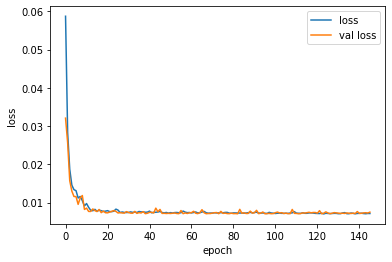

In [22]:
if mode == 'train':
    plt.figure(2111)
    plt.plot(train_history.history['loss'], label = 'loss')
    plt.plot(train_history.history['val_loss'], label = 'val loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [23]:
# trained_model = Model(inputs=encoder_inputs, outputs=ae_outputs, name='VAE')
nn_model.load_weights(weights_filepath)
nn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Field (InputLayer)          [(None, 6)]               0         
                                                                 
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 1024)              263168    
                                                                 
 dense_4 (Dense)             (None, 2048)              2099200   
                                                                 
 dense_5 (Dense)             (None, 1024)              209817

In [24]:
Y_pred = nn_model.predict(X_test)
# Y_pred = preprocessor_output.inverse_transform(Y_pred)

664/664 [==============================] - 1s 816us/step


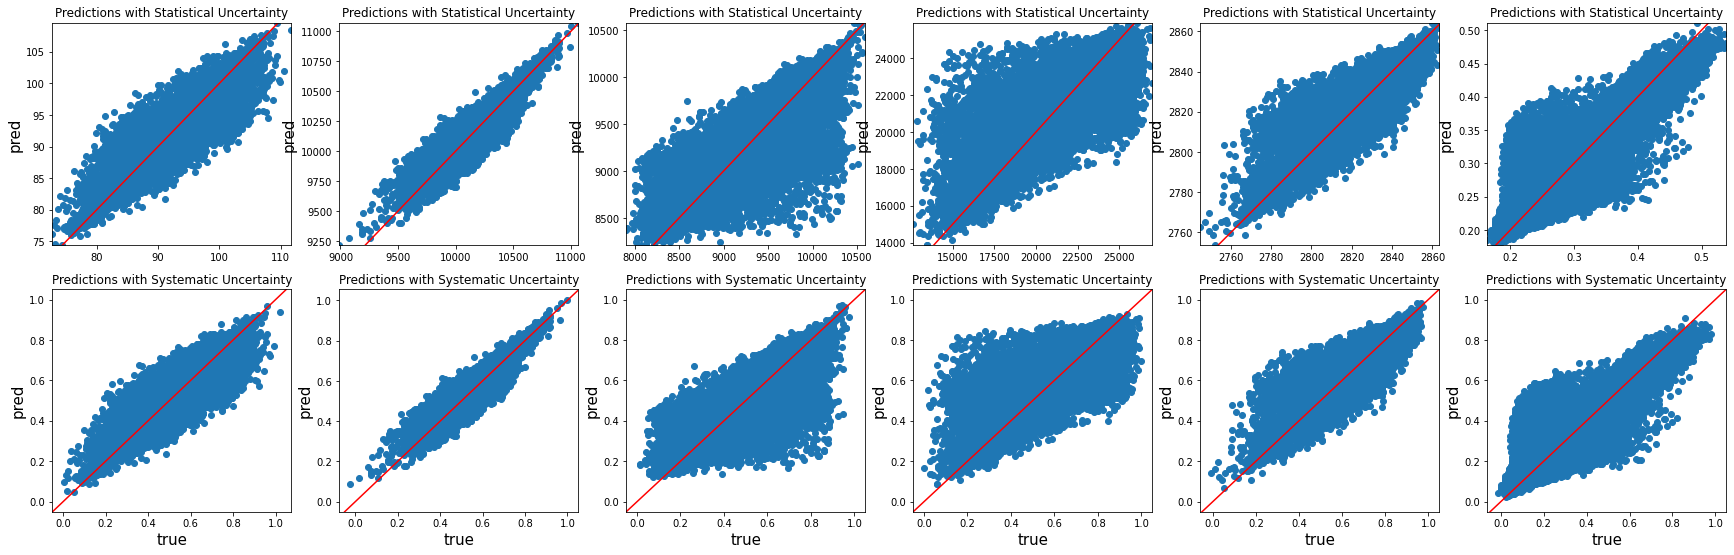

In [25]:
f, a = plt.subplots(2, Y_train.shape[1], figsize=(Y_train.shape[1]*5, 9))

########

for plot_id in range(Y_train.shape[1]):


    a[0, plot_id].title.set_text('Predictions with Statistical Uncertainty')
    a[0, plot_id].set_ylabel('pred', fontsize=15)
    a[0, plot_id].axline([0, 0], [1, 1], color = 'r')
    a[0, plot_id].set_xlim(preprocessor_output.inverse_transform(Y_test)[:, plot_id].min(), preprocessor_output.inverse_transform(Y_test)[:, plot_id].max())
    a[0, plot_id].set_ylim(preprocessor_output.inverse_transform(Y_pred)[:, plot_id].min(), preprocessor_output.inverse_transform(Y_pred)[:, plot_id].max())

    a[0, plot_id].scatter(preprocessor_output.inverse_transform(Y_test)[:, plot_id], preprocessor_output.inverse_transform(Y_pred)[:, plot_id])


    ########



    a[1, plot_id].title.set_text('Predictions with Systematic Uncertainty')
    a[1, plot_id].set_xlabel('true', fontsize=15)
    a[1, plot_id].set_ylabel('pred', fontsize=15)
    a[1, plot_id].axline([0, 0], [1, 1], color = 'r')
    
    # a[1, plot_id].set_xlim(Y_test[:, plot_id].min(), Y_test[:, plot_id].max())
    # a[1, plot_id].set_ylim(Y_pred[:, plot_id].min(), Y_pred[:, plot_id].max())
    a[1, plot_id].scatter(Y_test[:, plot_id], Y_pred[:, plot_id])


plt.savefig('plots/dh_test')
# plt.show()

In [26]:
testing_data_op = preprocessor_output.inverse_transform(Y_test)
testing_data_pred = preprocessor_output.inverse_transform(Y_pred)

for op in range(Y_train.shape[1]):
    var_true = testing_data_op[:,op]
    var_pred = testing_data_pred[:,op]

    pdiff = abs((var_true - var_pred)*200/(var_true+var_pred))

    # np.savetxt('pdiff_var'+ str(op) + '.dat',pdiff,delimiter='  ',fmt='%12.5G')
    # np.savetxt('testvar_'+ str(op) + '.dat',testing_data_op[:,op],delimiter='  ',fmt='%12.5G')
    # np.savetxt('predvar_'+ str(op) + '.dat',testing_data_pred[:,op],delimiter='  ',fmt='%12.5G')

    dat = np.array([testing_data_op[:,op],testing_data_pred[:,op],pdiff])
    dat = dat.T
    np.savetxt('out/true_pred_diff_'+ str(op) + '.dat', dat ,delimiter='  ',fmt='%12.5G')

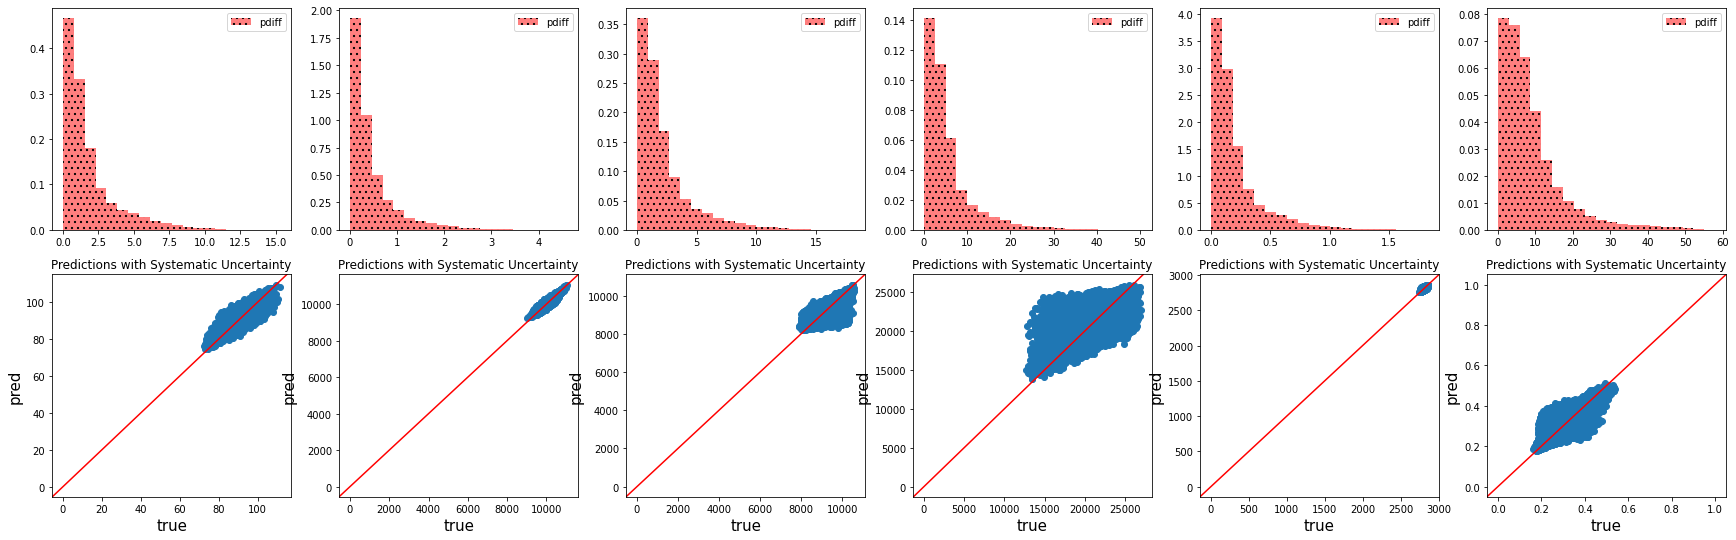

In [27]:
f, a = plt.subplots(2, Y_train.shape[1], figsize=(Y_train.shape[1]*5, 9))

for op in range(Y_train.shape[1]):
    load_dat = np.loadtxt('out/true_pred_diff_'+ str(op) + '.dat')
    a[0, op].hist(load_dat[:, 2], bins=20, histtype='stepfilled', color='red', hatch='..', label='pdiff', alpha=0.5, density=True);
    a[0, op].legend()
    
    
    a[1, op].scatter(load_dat[:, 0],
                  load_dat[:, 1])
    a[1, op].title.set_text('Predictions with Systematic Uncertainty')
    a[1, op].set_xlabel('true', fontsize=15)
    a[1, op].set_ylabel('pred', fontsize=15)
    a[1, op].axline([0, 0], [1, 1], color = 'r')
    
    

plt.savefig('plots/pdiff_hist')